# MARATONA BEHIND THE CODE 2020

## DESAFIO 2: PARTE 1
- Autor: Rodrigo Lima

# Parte 1. Importando os pacotes

In [50]:
import numpy as np
import pandas as pd

import matplotlib as m
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import imblearn
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 14,6

# Parte 2. Carregando os Dados

In [22]:
# Carregando o dataset da competição
dados = pd.read_csv('../data/training_dataset.csv')

# Parte 3. Feature Engineering

In [23]:
# Funcao para preencher os dados missing de algumas colunas
def preenche_missing(df):
    # Remove todos os registros que tem algum dado vazio de algumas colunas
    df.dropna(axis='index', how='any', subset=['pretende_fazer_cursos_lit',
                                               'interesse_mba_lit',
                                               'certificados'], inplace=True)

    #df['graduacao']             = df['graduacao'].fillna('Outros')
    #df['universidade']          = df['universidade'].fillna('Outros')
    #df['como_conheceu_lit']     = df['como_conheceu_lit'].fillna('Outros')
    #df['organizacao']           = df['organizacao'].fillna('Outros')
    #df['profissao']             = df['profissao'].fillna('Outros')
    #df['horas_semanais_estudo'] = df['horas_semanais_estudo'].fillna(0)
    
    impute_zeros = SimpleImputer(
                                    missing_values=np.nan,
                                    strategy='constant',
                                    fill_value=0,
                                    verbose=0,
                                    copy=True
                                )
    
    impute_zeros.fit(X=df)

    # Reconstruindo um Pandas DataFrame com os resultados
    df = pd.DataFrame.from_records(
            data = impute_zeros.transform(
            X    = df
        ),
        columns=df.columns
    )    

    return df

In [24]:
# Funcao para trabalhar as features
def fe(df):
    # Cria novas colunas integradas
    #df['modulos_em_andamento']   = df['modulos_iniciados'] - df['modulos_finalizados']
    #df[df['modulos_em_andamento'] < 0] = 0
    #df['modulos_restante']       = df['total_modulos'] - df['modulos_finalizados']
    #df['terminou_todos_modulos'] = df['modulos_restante'].apply(lambda x: 1 if x == 0 else 0)
    #df['modulos_em_andamento']   = df['modulos_em_andamento'].fillna(0)

    # Removendo colunas unicas
    df = df.drop(['id','universidade','graduacao','organizacao','como_conheceu_lit','importante_ter_certificado'], axis = 1)

    # Categorizar a coluna target
    #df['categoria'] = df['categoria'].astype("category").cat.codes
    
    return df

In [25]:
# Funcao para transformar features categoricas em numericas
def fe_cat_num(df):
    # Create o mapa para graduacao
    graduacao_map = {'Outros'        :-999, 
                     'SEM FORMAÇÃO'  :1,
                     'Bacharelado'   :2,
                     'Licenciatura'  :2,
                     'Tecnólogo'     :2,
                     'MBA'           :3,
                     'Especialização':3}

    # Realiza o replace dos dados para feature graduacao
    #df['graduacao'] = df['graduacao'].replace(graduacao_map)

    # Tratando variáveis categóricas com o método Pandas ``get_dummies()''
    df = pd.get_dummies(df, columns=['profissao'])

    return df

In [26]:
# Tratamento de dados missing para features categoricas    
dados = preenche_missing(dados)    

# Feature Engineering
dados = fe(dados)   

# Tratamento de dados categoricos
dados = fe_cat_num(dados)    


In [27]:
print(dados.shape)
dados.head(10)

(10852, 21)


,pretende_fazer_cursos_lit,interesse_mba_lit,horas_semanais_estudo,total_modulos,modulos_iniciados,modulos_finalizados,certificados,categoria,profissao_0,profissao_Advogado,...,profissao_Analista Senior,profissao_Assessor,profissao_Coordenador,profissao_Diretor,profissao_Engenheiro,profissao_Gerente,profissao_Outros,profissao_SEM EXPERIÊNCIA,profissao_Supervisor,profissao_Sócio/Dono/Proprietário
0,1.0,1.0,6.0,28.0,5.0,4.0,0.0,perfil6,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0.0,0.0,6.0,66.0,36.0,34.0,0.0,perfil2,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1.0,1.0,10.0,27.0,27.0,27.0,0.0,perfil2,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,1.0,0.0,66.0,52.0,50.0,0.0,perfil2,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,2.0,31.0,0.0,13.0,0.0,perfil4,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0.0,0.0,6.0,27.0,13.0,12.0,0.0,perfil2,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0.0,0.0,9.0,51.0,49.0,49.0,0.0,perfil2,0,0,...,0,0,0,0,0,1,0,0,0,0
7,1.0,1.0,3.0,10.0,5.0,1.0,0.0,perfil6,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0.0,0.0,2.0,10.0,3.0,1.0,0.0,perfil6,0,1,...,0,0,0,0,0,0,0,0,0,0
9,0.0,0.0,4.0,40.0,4.0,4.0,0.0,perfil6,1,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# Funcao para verificar valores missing no dataset
def check_missing(df, display = 10):
    temp_df = df.copy()
    df_nan = (temp_df.isnull().sum() / len(temp_df)) * 100
    missing_data = pd.DataFrame({'Missing n': temp_df.isnull().sum(),'% Missing' :df_nan})
    if missing_data['Missing n'].sum() == 0:
        return print('Ótimo! Não há mais valores faltantes neste dataset.')
    else:
        return missing_data.sort_values('% Missing', ascending = False).head(display)

In [29]:
# Verificando as colunas com dados missing do dataset
check_missing(dados, display = 15)

Ótimo! Não há mais valores faltantes neste dataset.


# Parte 4. Machine Learning
> Utilizarei o algoritmo Random Forest

### Split dos dados em Treino e Teste

In [30]:
dados.columns

Index(['pretende_fazer_cursos_lit', 'interesse_mba_lit',
       'horas_semanais_estudo', 'total_modulos', 'modulos_iniciados',
       'modulos_finalizados', 'certificados', 'categoria', 'profissao_0',
       'profissao_Advogado', 'profissao_Analista', 'profissao_Analista Senior',
       'profissao_Assessor', 'profissao_Coordenador', 'profissao_Diretor',
       'profissao_Engenheiro', 'profissao_Gerente', 'profissao_Outros',
       'profissao_SEM EXPERIÊNCIA', 'profissao_Supervisor',
       'profissao_Sócio/Dono/Proprietário'],
      dtype='object')

In [31]:
features = dados[['pretende_fazer_cursos_lit', 'interesse_mba_lit',
       'horas_semanais_estudo', 'total_modulos', 'modulos_iniciados',
       'modulos_finalizados', 'certificados','profissao_0',
       'profissao_Advogado', 'profissao_Analista', 'profissao_Analista Senior',
       'profissao_Assessor', 'profissao_Coordenador', 'profissao_Diretor',
       'profissao_Engenheiro', 'profissao_Gerente', 'profissao_Outros',
       'profissao_SEM EXPERIÊNCIA', 'profissao_Supervisor',
       'profissao_Sócio/Dono/Proprietário']]

target = dados['categoria']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=133)

### Aplicando balanceamento nos dados de treino

In [33]:
# Criamos o objeto SMOTE
sm = SMOTE(random_state = 337)

# Treinamos o balanceador SMOTE
X_bal, Y_bal = sm.fit_sample(X_train, y_train)

# Aplicando a mesma escala nos dados
X_bal = MinMaxScaler().fit_transform(X_bal)

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X_bal = StandardScaler().fit_transform(X_bal)


### Realizando o treinamento do modelo
> Vou utilizar a técnica de Cross-Validation

In [42]:
# Definindo os valores para o número de folds
num_folds = 3
seed = 133

# Preparando a lista de modelos
model_rf = RandomForestClassifier()

kfold = KFold(n_splits = num_folds, random_state = seed)
cv_results = cross_val_score(model_rf, X_bal, Y_bal, cv = kfold, scoring = 'f1_macro')

msg = "RF: %f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

RF: 0.650864 (0.153592)


In [45]:
# Definindo os valores para o número de folds
num_folds = 3
seed = 133

# Preparando a lista de modelos
model_gb= GradientBoostingClassifier()

kfold = KFold(n_splits = num_folds, random_state = seed)
cv_results = cross_val_score(model_gb, X_bal, Y_bal, cv = kfold, scoring = 'f1_macro')

msg = "GB: %f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

GB: 0.654992 (0.163692)


### Realizando a validação do modelo com dados de teste

In [46]:
# Aplicando a mesma escala nos dados
X_test_bal = MinMaxScaler().fit_transform(X_test)

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X_test_bal = StandardScaler().fit_transform(X_test_bal)

# Realizando as previsões
rf_y_pred = cross_val_predict(model_gb, X_test_bal, y_test, cv=num_folds)

# Relatório de Classificação
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

     perfil1       0.84      0.76      0.80       333
     perfil2       0.84      0.87      0.85       578
     perfil3       0.68      0.70      0.69       130
     perfil4       0.77      0.72      0.74       244
     perfil5       0.81      0.78      0.79       250
     perfil6       0.82      0.86      0.84       636

    accuracy                           0.81      2171
   macro avg       0.79      0.78      0.79      2171
weighted avg       0.81      0.81      0.81      2171



### Visualizando o desempenho do modelo

Text(0.5, 1.0, 'Confusion Matrix')

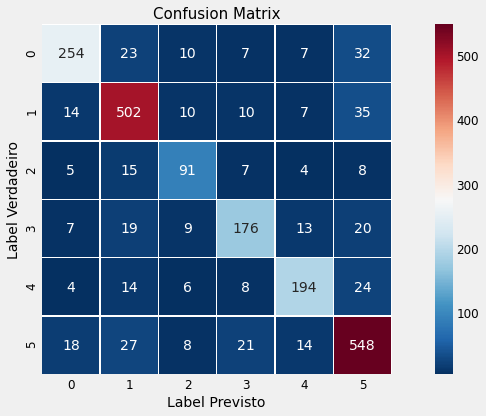

In [48]:
# Matriz de Confusão
sns.heatmap(confusion_matrix(y_test, rf_y_pred), 
            annot = True, 
            fmt = ".0f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title("Confusion Matrix", size = 15)

In [53]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    #"criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.8, 0.9, 1.0],
    "n_estimators":[10]
    }

clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=3, n_jobs=-1)

In [54]:
clf.fit(X_bal, Y_bal)
print(clf.best_params_)

KeyboardInterrupt: 